In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score

import tensorflow
from tensorflow import keras
import keras_tuner as kt


from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

In [23]:
def Sliding_Window(df_temp,win_len,stride):
    X=[]
    Y=[]
    T=[]

    for i in np.arange(0,len(df_temp)-(win_len),stride):
        temp = df_temp.iloc[i:i+win_len,[1,2]].values

        X.append(temp)
        Y.append(df_temp.iloc[i+win_len,-1])
        T.append(df_temp.iloc[i+win_len,0])

    return np.array(X),np.array(Y),np.array(T)

- The data imported from the Matlab-simulink model are in **csv format**, with name as "{Fault}_noise_02.csv"
- **M** number of such files are present, coresponding to **M** faults.
- In each fault file, the fault is introduced at **t=\[1000,1500\]s** for incipient fault and **t=\[2000,2500\]s** for the step fault.

The Goal is to extract only the values of residuals between t=\[1000,1500\]s and t=\[2000,2500\]s. These values are then stored in a **new DataFrame**, which contains the residual information for all the fault classes. 

In [24]:
def PreprocessData(working_cond,win_len,stride):
    Path = r'.\ALL_DC_motor_Data\Ua_{}V_Noise_2_perct'.format(working_cond) # Path of the folder containing CSV files from that working condition
    file_name = os.listdir(path=Path) 


    X_full, Y_full = [], []

    for f in file_name : #Iterate through each file, which coresponds to a Fault
        csv_path =  os.path.join(Path,f)
        df = pd.read_csv(csv_path)

        temp_df_1=df[(df.time > 1050) & (df.time< 1500)]  # Incipient-Taking samples after which the Parameter fault was introduced

        x1, y1, _ = Sliding_Window(temp_df_1,win_len,stride)

        temp_df_2=df[(df.time > 2050) & (df.time< 2500)]  # Step -Taking samples after which the Parameter fault was introduced

        x2, y2, _ = Sliding_Window(temp_df_2,win_len,stride)

        x_temp, y_temp = np.concatenate((x1,x2),axis=0),np.concatenate((y1,y2),axis=0)

        X_full.append(x_temp)
        Y_full.append(y_temp)


    X_full = np.array(X_full)
    X_full = np.reshape(X_full, (-1,X_full.shape[2],X_full.shape[3]))

    Y_full = np.array(Y_full)
    Y_full = np.reshape(Y_full, (-1))

    return X_full, Y_full


In [33]:
WL=20
S=40

X_120, Y_120 = PreprocessData(working_cond=120,win_len=WL,stride=S)
X_80, Y_80  = PreprocessData(working_cond=80,win_len=WL,stride=S)
X_40, Y_40 = PreprocessData(working_cond=40,win_len=WL,stride=S)

In [34]:
X_full = np.concatenate((X_40,X_80,X_120))
Y_full = np.concatenate((Y_40,Y_80,Y_120))

print(f"length of total data = {len(X_full)}")

length of total data = 5376


In [35]:
fault_label_dict = {'Healthy':0, 'Re':1, 'Rm':2, 'I':3, 'W':4, 'K':5,  'Re & Rm':6, 'I & W':7}

Y_full = np.vectorize(fault_label_dict.get)(Y_full)

## Resample the Data

In [36]:
def n_samples_per_class(X_sc,Y,num_samples):
    from sklearn.utils import resample
    if len(X_sc.shape)==3:
        # Initialize empty arrays for the sampled data
        x_sample = np.zeros((num_samples * np.unique(Y).size, X_sc.shape[1], X_sc.shape[2]))
    else:
        x_sample = np.zeros((num_samples * np.unique(Y).size, X_sc.shape[1]))
    y_sample = np.zeros(num_samples * np.unique(Y).size)

    # Loop over each class label and sample from the corresponding data points
    for i, label in enumerate(np.unique(Y)):
        class_indices = np.where(Y == label)[0]
        sampled_indices = resample(class_indices, n_samples=num_samples, replace=False, random_state=0)
        x_sample[i*num_samples:(i+1)*num_samples] = X_sc[sampled_indices]
        y_sample[i*num_samples:(i+1)*num_samples] = Y[sampled_indices]

    return x_sample,y_sample

In [37]:
def Scale_Encode(X_full,Y_full, num_training_samples):
    # Train Test split
    X_train,y_train=n_samples_per_class(X_full,Y_full,num_samples=num_training_samples)
    X_test,y_test = X_full, Y_full

    # Standardising the data
    scaler = StandardScaler()
    X_train_sc = scaler.fit_transform(X_train.reshape(-1,X_train.shape[-1])).reshape(X_train.shape)
    X_test_sc = scaler.transform(X_test.reshape(-1,X_test.shape[-1])).reshape(X_test.shape)
    # One Hot encoding
    encoder = OneHotEncoder(sparse=False)
    y_train_ohe = encoder.fit_transform(y_train.reshape(-1,1))
    y_test_ohe = encoder.transform(y_test.reshape(-1,1))

    return X_train_sc, X_test_sc, y_train_ohe, y_test_ohe, scaler, encoder

# Tuned CNN model

In [38]:
def CNN_model(encoder,X_train_transformed):
    from tensorflow.keras.models import Sequential,Model
    from tensorflow.keras.layers import Input,Dense, Dropout, Flatten
    from tensorflow.keras.layers import Conv1D, MaxPooling1D

    # Hyperparameters obtained aftre tuning
    num_k1=112
    k1 = 5
    num_d1=96
    alpha = 0.001

    num_classes=len(encoder.categories_[0])

    cnn_model = Sequential()
    cnn_model.add(Conv1D(num_k1, kernel_size=(k1),activation='relu',input_shape=(X_train_transformed.shape[1],X_train_transformed.shape[2]),padding='same'))
    cnn_model.add(MaxPooling1D((2),padding='same'))
    cnn_model.add(Flatten())
    cnn_model.add(Dense(num_d1, activation='relu'))
    cnn_model.add(Dense(num_classes, activation='sigmoid'))

    cnn_model.compile(loss='binary_crossentropy', optimizer=tensorflow.keras.optimizers.Adam(learning_rate=alpha),metrics=['accuracy'])
    
    return cnn_model

# AI Training

# number of samples Vs F1 score

In [56]:


f1_RF = []
f1_KNN = []
f1_SVM = []
f1_ANN = []

for N in [1,2,4,8,16,32,64,100,128]:
    print(f'Experiment for N = {N}')
    X_train_sc, X_test_sc, y_train_ohe, y_test_ohe, scaler, encoder = Scale_Encode(X_full,Y_full, num_training_samples=N)
    X_train_sc, X_test_sc = X_train_sc.reshape(X_train_sc.shape[0],-1), X_test_sc.reshape(X_test_sc.shape[0],-1)
    y_train, y_test = encoder.inverse_transform(y_train_ohe), encoder.inverse_transform(y_test_ohe)


    # SVM 
    svc = SVC().fit(X_train_sc,y_train)
    y_pred_svc = svc.predict(X_test_sc)
    f1_SVM.append(f1_score(y_test,y_pred_svc,average='micro'))

    # KNN
    KNC = KNeighborsClassifier().fit(X_train_sc,y_train)
    y_pred_knc = KNC.predict(X_test_sc)
    f1_KNN.append(f1_score(y_test,y_pred_knc,average='micro'))

    # RF
    RF = RandomForestClassifier().fit(X_train_sc,y_train)
    y_pred_rf = RF.predict(X_test_sc)
    f1_RF.append(f1_score(y_test,y_pred_rf,average='micro'))

    # ANN
    ANN = MLPClassifier(max_iter=300).fit(X_train_sc,y_train)
    y_pred_ann = ANN.predict(X_test_sc)
    f1_ANN.append(f1_score(y_test,y_pred_ann,average='micro'))

# CNN with raw sensor signals
f1_CNN = []

for N in [1,2,4,8,16,32,64,100,128]:
    print(f'CNN -raw sensor Experiment for N = {N}')
    X_train_sc, X_test_sc, y_train_ohe, y_test_ohe, scaler, encoder = Scale_Encode(X_full,Y_full, num_training_samples=N)
    cnn_model=CNN_model(encoder,X_train_sc)
    callback = tensorflow.keras.callbacks.EarlyStopping(monitor='accuracy', patience=10,restore_best_weights=True)
    cnn_model.fit(X_train_sc,
                y_train_ohe,
                epochs=200,
                batch_size=int(0.1*len(X_train_sc)),              
                callbacks=[callback],
                shuffle=True,verbose=0)

    y_pred=cnn_model.predict(X_test_sc)
    y_pred=encoder.inverse_transform(y_pred)
    y_test = encoder.inverse_transform(y_test_ohe)

    f1_CNN.append(f1_score(y_test,y_pred,average='micro'))


Experiment for N = 1


c:\Users\Administrator\miniconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Administrator\miniconda3\envs\tensorflow\lib\site-packages\sklearn\neighbors\_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_10660\3625372609.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RF = RandomForestClassifier().fit(X_train_sc,y_train)
c:\Users\Administrator\miniconda3\envs\tensorflow\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1118: DataConve

Experiment for N = 2


c:\Users\Administrator\miniconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Administrator\miniconda3\envs\tensorflow\lib\site-packages\sklearn\neighbors\_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_10660\3625372609.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RF = RandomForestClassifier().fit(X_train_sc,y_train)
c:\Users\Administrator\miniconda3\envs\tensorflow\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1118: DataConve

Experiment for N = 4


C:\Users\Administrator\AppData\Local\Temp\ipykernel_10660\3625372609.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RF = RandomForestClassifier().fit(X_train_sc,y_train)
c:\Users\Administrator\miniconda3\envs\tensorflow\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1118: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Administrator\miniconda3\envs\tensorflow\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Administrator\miniconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y w

Experiment for N = 8


C:\Users\Administrator\AppData\Local\Temp\ipykernel_10660\3625372609.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RF = RandomForestClassifier().fit(X_train_sc,y_train)
c:\Users\Administrator\miniconda3\envs\tensorflow\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1118: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Administrator\miniconda3\envs\tensorflow\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Administrator\miniconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y w

Experiment for N = 16


C:\Users\Administrator\AppData\Local\Temp\ipykernel_10660\3625372609.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RF = RandomForestClassifier().fit(X_train_sc,y_train)
c:\Users\Administrator\miniconda3\envs\tensorflow\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1118: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Administrator\miniconda3\envs\tensorflow\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Administrator\miniconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y w

Experiment for N = 32


C:\Users\Administrator\AppData\Local\Temp\ipykernel_10660\3625372609.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RF = RandomForestClassifier().fit(X_train_sc,y_train)
c:\Users\Administrator\miniconda3\envs\tensorflow\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1118: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Administrator\miniconda3\envs\tensorflow\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Administrator\miniconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y w

Experiment for N = 64


c:\Users\Administrator\miniconda3\envs\tensorflow\lib\site-packages\sklearn\neighbors\_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_10660\3625372609.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RF = RandomForestClassifier().fit(X_train_sc,y_train)
c:\Users\Administrator\miniconda3\envs\tensorflow\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1118: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Administrator\miniconda3\envs\tensorflow\lib\site-packages\sklearn\neural_network\_multilayer_perceptr

Experiment for N = 100


c:\Users\Administrator\miniconda3\envs\tensorflow\lib\site-packages\sklearn\neighbors\_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_10660\3625372609.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RF = RandomForestClassifier().fit(X_train_sc,y_train)
c:\Users\Administrator\miniconda3\envs\tensorflow\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1118: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Administrator\miniconda3\envs\tensorflow\lib\site-packages\sklearn\neural_network\_multilayer_perceptr

Experiment for N = 128


c:\Users\Administrator\miniconda3\envs\tensorflow\lib\site-packages\sklearn\neighbors\_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_10660\3625372609.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RF = RandomForestClassifier().fit(X_train_sc,y_train)
c:\Users\Administrator\miniconda3\envs\tensorflow\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1118: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Administrator\miniconda3\envs\tensorflow\lib\site-packages\sklearn\neural_network\_multilayer_perceptr

CNN -raw sensor Experiment for N = 1
CNN -raw sensor Experiment for N = 2
CNN -raw sensor Experiment for N = 4
CNN -raw sensor Experiment for N = 8
CNN -raw sensor Experiment for N = 16
CNN -raw sensor Experiment for N = 32
CNN -raw sensor Experiment for N = 64
CNN -raw sensor Experiment for N = 100
CNN -raw sensor Experiment for N = 128


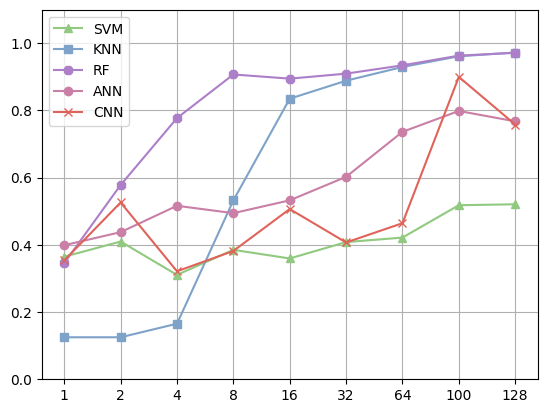

In [57]:
plt.plot([str(x) for x in [1,2,4,8,16,32,64,100,128]],f1_SVM,color='#90c97f',marker='^', linewidth=1.5, markersize=6)
plt.plot([str(x) for x in [1,2,4,8,16,32,64,100,128]],f1_KNN,color='#7fa2c9',marker='s', linewidth=1.5, markersize=6)
plt.plot([str(x) for x in [1,2,4,8,16,32,64,100,128]],f1_RF,color='#ad7fc9',marker='8', linewidth=1.5, markersize=6)
plt.plot([str(x) for x in [1,2,4,8,16,32,64,100,128]],f1_ANN,color='#c97fa6',marker='o', linewidth=1.5, markersize=6)
plt.plot([str(x) for x in [1,2,4,8,16,32,64,100,128]],f1_CNN,color='#e0635a',marker='x', linewidth=1.5, markersize=6)

plt.ylim([0,1.1])
plt.grid(visible=True)
plt.legend(['SVM','KNN', 'RF', 'ANN', 'CNN'])
plt.show()

# PCA visualization after training with N = 8

In [101]:
X_train_sc, X_test_sc, y_train_ohe, y_test_ohe, scaler, encoder = Scale_Encode(X_full,Y_full, num_training_samples=8)
y_train, y_test = encoder.inverse_transform(y_train_ohe), encoder.inverse_transform(y_test_ohe)
cnn_model=CNN_model(encoder,X_train_sc)
callback = tensorflow.keras.callbacks.EarlyStopping(monitor='accuracy', patience=10,restore_best_weights=True)
cnn_model.fit(X_train_sc,
            y_train_ohe,
            epochs=200,
            batch_size=int(0.1*len(X_train_sc)),              
            callbacks=[callback],
            shuffle=True,verbose=0)


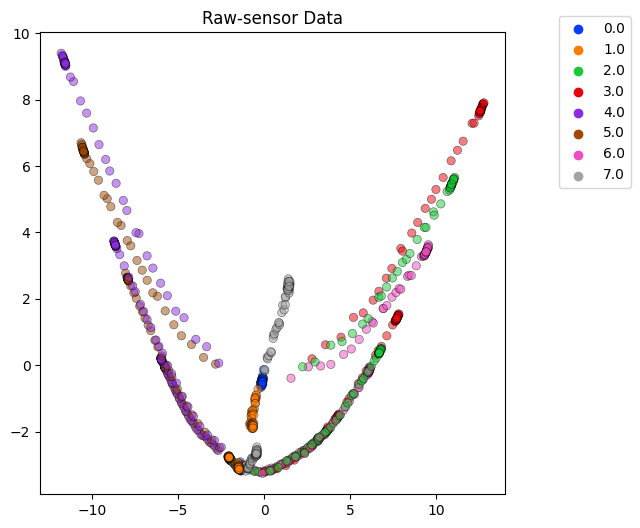

In [103]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tensorflow.keras.models import Sequential,Model

projection_2d = Model(cnn_model.layers[0].input, cnn_model.layers[-2].output)

embd = projection_2d.predict(X_test_sc)

pca = PCA(n_components=2)
x_test_embd = pca.fit_transform(embd)


f, ax = plt.subplots(figsize=(6,6))
sns.scatterplot(x=x_test_embd[::5,0], y=x_test_embd[::5,1] , hue=y_test[::5].reshape(-1),palette="bright",edgecolor='black',alpha=0.5 )
plt.title('Raw-sensor Data')
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()
